# My implementation of policy gradient in CartPole

Author: Haitao Gao
Date: 3 Oct 2023
env: gymanasuim.CartPole-v1

Algorithm:
1. init the policy network

2. run an episode

3. collect the reward and every timestep discounted returns (rewards to go)

4. compute the gradient and update the parameters

5. repeat the loop (step2 - step4) when the fix the conditions

## import some libs and check the info of env

In [72]:
import gymnasium as gym
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

In [73]:
env = gym.make('CartPole-v1',render_mode = 'rgb')

In [74]:
state_space = env.observation_space.shape[0]
action_space = env.action_space.n
print(f'state space: {state_space}')
print(f'action space: {action_space}')

state space: 4
action space: 2


In [75]:
state,info = env.reset()
state

array([-0.00275117, -0.00286075, -0.04163363,  0.04228757], dtype=float32)

## Build the policy network

![reinforce network](/Users/gaohaitao/robotics-tutorial/Algotithms/reinforce.png)

*Note:* the figure is from hugging face DRL course!

In [76]:
import torch
import torch.nn as nn
import torch.nn.functional as F
# Note: torch.functional is difference with torch.nn.functional
import torch.optim as optim
# this is new lib in the policy gradient which is different with Q-learning
from torch.distributions import Categorical

class PolicyNet(nn.Module):
    """simply use the MLP since the env is very simple """
    def __init__(self,
                 state_space,
                 action_space,
                 lr,
                 device,
                 fc1_dim = 16,
                 fc2_dim = 16):
        super(PolicyNet,self).__init__()
        
        self.state_space = state_space
        self.action_space = action_space
        self.lr = lr
        self.device = device
        
        self.fc1 = nn.Linear(state_space,fc1_dim)
        self.fc2 = nn.Linear(fc1_dim,fc2_dim)
        self.fc3 = nn.Linear(fc2_dim,action_space)
        # self.loss = []
        self.optimizer = optim.Adam(self.parameters(),lr = self.lr)
        self.to(self.device)
        
    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        
        return F.softmax(self.fc3(x),dim=1)

## Let's build an agent that use the REINFORCE algorithm to play the game

![pseudocode](/Users/gaohaitao/robotics-tutorial/Algotithms/pg_pseudocode.png)

In [77]:
class Agent():
    def __init__(self,
                 env: gym.envs,
                 state_space: int,
                 action_space: int,
                 lr: float,
                 device: torch.device,
                 gamma: float, # that means the discounted returns
                 n_training_episodes: int,
                 max_t):
        
        self.env = env
        self.state_space = state_space
        self.action_space = action_space
        self.lr = lr
        self.device = device
        self.gamma = gamma
        self.n_training_epsidoes = n_training_episodes
        self.max_t = max_t
        
        self.policy_net = PolicyNet(self.state_space,self.action_space,self.lr,self.device)
        
    def act(self,state):
        """the agent choose an agent according to the policy_theta and state"""
        # we should convert the state to torch.tensor since we need use the nn.module
        # state is a ndarray
        state = torch.from_numpy(state).float().unsqueeze(0).to(self.device)
        # the action space is 2, so the ouput will be [p1,p2]
        probs = self.policy_net(state).cpu()
        # torch.distributions contains "parameterizable" probability distributions and sample function
        # the tutorial of this packages is: https://pytorch.org/docs/stable/distributions.html
        m = Categorical(probs)
        action = m.sample()
        return action.item(), m.log_prob(action)
    
    def step(self,action):
        """the agent take the choosen action and obtain the next observation and immedient reward"""
        next_obs, reward, terminated, truncated, info = self.env.step(action)
        done = terminated or truncated
        return next_obs, reward, done
    
    def update(self,rewards,log_probs):
        """the agent will update the parameters when it collects a series of actions and returns"""
        # formula: L(\theta) = \frac{1}{T} * \sum_{t=0}^{T-1} G_t * log \pi_theta(At | St)
        # optimize the L(\theta)
        policy_loss = []
        for log_prob,disc_return in zip(log_probs,rewards):
            policy_loss.append(-1 * log_prob * disc_return)
        policy_loss = torch.cat(policy_loss).sum()
        
        self.policy_net.optimizer.zero_grad()
        policy_loss.backward()
        self.policy_net.optimizer.step()
        
    def train(self):
        """train the agent N_training_episodes and improve the perfermance"""
        # define some datastructures to store the infos
        scores_deque = deque(maxlen=100) 
        scores = []
        avg_scores = []
        # Algorithm line3
        for episode in range(self.n_training_epsidoes):
            # init some lists to store information every episode
            saved_log_probs = []       
            rewards = []
            
            # init the env
            state,info = self.env.reset()
            # loop max_t
            for t in range(self.max_t):
                # Algorithm line 4
                action,log_prob_action = self.act(state)
                saved_log_probs.append(log_prob_action)
                next_obs,reward,done = self.step(action)
                rewards.append(reward)
                if done:
                    break
                # I forget this operation firstly and the scores don't increase :(
                state = next_obs
            scores_deque.append(sum(rewards))
            scores.append(sum(rewards))
            avg_scores.append(np.mean(scores_deque))
            
            # Algorithm line 6
            returns = deque(maxlen=self.max_t)
            n_steps = len(rewards)
            # compute the discounted returns
            for t in range(n_steps)[::-1]:
                disc_return_t = (returns[0] if len(returns)>0 else 0)
                returns.appendleft(rewards[t] + self.gamma * disc_return_t)
                
            # standardization of returns is employed to make training more stable
            eps = np.finfo(np.float32).eps.item()
            returns = torch.tensor(returns)
            returns = (returns - returns.mean()) / (returns.std() + eps)
            
            # Algorithm line 7 and line 8
            self.update(returns,saved_log_probs)
            
            
            if episode % 100 == 0:
                print(f'episode: {episode} | average score: {np.mean(scores_deque)}')
            
        fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
        fig.suptitle('Training Progress')

        ax1.plot(scores, label='Episode Scores', color='b')
        ax1.set_xlabel('Episode')
        ax1.set_ylabel('scores', color='b')
        ax1.tick_params(axis='y', labelcolor='b')

        ax2.plot(avg_scores, label='Episode Average Score', color='r')
        ax2.set_xlabel('Episode')
        ax2.set_ylabel('Average Score', color='r')
        ax2.tick_params(axis='y', labelcolor='r')

        plt.show()
        
            
        
        

## instance the agent using hyperparameters

In [78]:
# Hyperparameters
state_space = env.observation_space.shape[0]
action_space = env.action_space.n
lr = 1e-2
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
gamma = 1.0
n_training_episodes = 1000
max_t = 1000

CartPoleAgent = Agent(
    env,
    state_space,
    action_space,
    lr,
    device,
    gamma,
    n_training_episodes,
    max_t
)

episode: 0 | average score: 13.0
episode: 100 | average score: 26.99
episode: 200 | average score: 129.76
episode: 300 | average score: 305.82
episode: 400 | average score: 111.57
episode: 500 | average score: 375.52
episode: 600 | average score: 459.36
episode: 700 | average score: 302.59
episode: 800 | average score: 330.39
episode: 900 | average score: 422.25


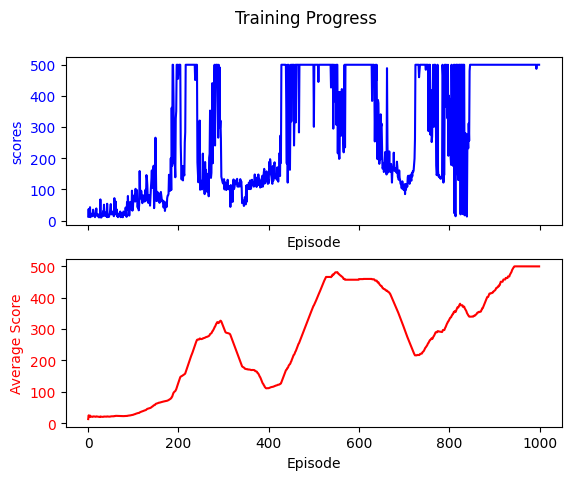

In [79]:
CartPoleAgent.train()